In [1]:
#SINCE NOW ALL FILES ARE IN A SEPARATE FUNCTIONS FOLDER, ALL PATH WERE CHANGED SO THAT THEY GO 1 FOLDER UP.
#example: '../derivatives/sub' instead of './derivatives/sub'


#Load data, filter, make folders
import numpy as np
import matplotlib.pyplot as plt

from main_meg_qc import initial_stuff

n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads, mags, grads, filtered_d, filtered_d_resamp, raw_cropped, raw=initial_stuff()

Opening raw data file ../data/sub_HT05ND16/210811/mikado-1.fif/...


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:8: RuntimeWarning: This filename (../data/sub_HT05ND16/210811/mikado-1.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file)


    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/../data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 

/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:64: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)


Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
253 events found
Event IDs: [    9    19    20    21    22    23    27    31 16393 16402 16403 16405
 16411 32741 32746 32749 32750 32759]
Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
8 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:64: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)
/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:79: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


In [2]:
#%% RMSE - general function to use in other functions
#STD CALCULATION IS MUCH LESS COdE BUT TAKES LONGER THAN RMSE

def RMSE(data_m_or_g):

    data_m_or_g=np.array(data_m_or_g) #convert to numpy array if it s not
    rmse_list=[]

    data_minentions=len(data_m_or_g.shape)
    if data_minentions==2: #if the data has raws and columns - iterate over raws. if input is 1 dimentional - juat calculate the whole thing.
        for i, dat_raw in enumerate (data_m_or_g):
            y_actual=dat_raw
            y_pred=y_actual.mean()
            rmse_data=np.sqrt(((y_pred - y_actual) ** 2).mean())
            rmse_list.append(rmse_data)
    elif data_minentions==1:
        y_actual=data_m_or_g
        y_pred=data_m_or_g.mean()
        rmse_data=np.sqrt(((y_pred - y_actual) ** 2).mean())
        rmse_list.append(rmse_data)
    else:
        print('Only 1 or 2 dimentional data is accepted, not more!')
        return

    rmse_nd=np.array(rmse_list) #conver to numpy array

    return rmse_nd

In [3]:
selected_mags = [item[1] for item in mags]
selected_grads = [item[1] for item in grads]
data_mags, times = filtered_d_resamp[selected_mags, :]  
data_grads, times = filtered_d_resamp[selected_grads, :]  

In [4]:
# Root mean squared error calculation (or STD - same result) over ALL data (not epoched):

def RMSE_meg_all(data=None, mags=mags, grads=grads, std_lvl=1, plotflag=True, sid='1'): #, min_duration_event=1, epoch_tmin=-0.2, epoch_tmax=1):
    #give path to directory and then it should auto find the data file when bids compliant.
    ##maybe distinguish between negative and positive std_lvl

    #plotflag - plot or no plot
    #sid - subject Id. Has to be a string , like '1'
    #mags, grads - channels like [name, index]
  

    # Separate data for mags and grads in 2 arrays.
    selected_mags = [item[1] for item in mags]
    selected_grads = [item[1] for item in grads]
    data_mags, times = data[selected_mags, :]  
    data_grads, times = data[selected_grads, :]  

    # %% Calculate STD or RMSE of each channel

    #Calculate RMSE for each channel (separated mags and grads) - for the entire time duration:
    std_mags = RMSE(data_mags)
    std_grads = RMSE(data_grads)

    #STD (if wanna use insted of RMSE. it will exactly replace the RMSE function above):
    #std_mags=np.std(data_mags, axis=1) #calculate std of all magnetometers (along second dimantion)
    #std_grads=np.std(data_grads, axis=1) #calculate std of all gradiometers (along second dimantion)


    # Check if channel data is within 1 std over all channels.
    # COMMENT: can use -3 to 3 (or other number) std istead of -1/+1 std, but this can adjusted later. 
    # 1 std is too narrow, gives way too many bad channels.

    std_std_mags=np.std(std_mags)
    std_std_grads=np.std(std_grads)

    mean_std_mags=np.mean(std_mags)
    mean_std_grads=np.mean(std_grads)

    ch_ind_large_std_mags= np.where(std_mags > mean_std_mags+std_lvl*std_std_mags) #find magn channels with largest std
    ch_ind_large_std_grads= np.where(std_grads > mean_std_grads+std_lvl*std_std_grads) 
    ch_ind_small_std_mags= np.where(std_mags < mean_std_mags-std_lvl*std_std_mags) #find magn channels with smallest std
    ch_ind_small_std_grads= np.where(std_grads < mean_std_grads-std_lvl*std_std_grads)

    magn_channel_big_std=np.array(mags)[ch_ind_large_std_mags] #find the name of the magn with largest std 
    grad_channel_big_std=np.array(grads)[ch_ind_large_std_grads]
    magn_channel_small_std=np.array(mags)[ch_ind_small_std_mags]
    grad_channel_small_std=np.array(grads)[ch_ind_small_std_grads]


    #This function simply makes a list of tuples. Each tuple is: name of channel, std value.
    #Each tuple represents channel with too big or too small std, calculated over whole data.

    def Channels_with_nonnormal_stds(ch_ind, all_stds_m_or_g, channels_big_std_names):
        channel_big_std_vals=all_stds_m_or_g[ch_ind]
        nonnormal_std_with_value=[]
        for id, val in enumerate (ch_ind[0]):
            new_tuple=(channels_big_std_names[id][0],  channel_big_std_vals[id])
            nonnormal_std_with_value.append(new_tuple)
        return(nonnormal_std_with_value)

    #Apply function above:
    m_big_std_with_value=Channels_with_nonnormal_stds(ch_ind_large_std_mags, std_mags, magn_channel_big_std)
    g_big_std_with_value=Channels_with_nonnormal_stds(ch_ind_large_std_grads, std_grads, grad_channel_big_std)
    m_small_std_with_value=Channels_with_nonnormal_stds(ch_ind_small_std_mags, std_mags, magn_channel_small_std)
    g_small_std_with_value=Channels_with_nonnormal_stds(ch_ind_small_std_grads, std_grads, grad_channel_small_std)


    #OLd STD figure:
    if plotflag==True:
        
        from matplotlib import pyplot as plt

        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle('STDs')
        ax1.plot(list(range(1, len(std_mags)+1)), std_mags, marker='o', linestyle = 'None')
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags]*len(std_mags))
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags-std_lvl*std_std_mags]*len(std_mags))
        ax1.plot(list(range(1, len(std_mags)+1)), [mean_std_mags+std_lvl*std_std_mags]*len(std_mags))
        ax1.set(xlabel='Magnetometer', ylabel='STD')

        ax2.plot(list(range(1, len(std_grads)+1)), std_grads, marker='o', linestyle = 'None')
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads]*len(std_grads))
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads-std_lvl*std_std_grads]*len(std_grads))
        ax2.plot(list(range(1, len(std_grads)+1)), [mean_std_grads+std_lvl*std_std_grads]*len(std_grads))
        ax2.set(xlabel='Gradiometer', ylabel='STD')

        plt.savefig('../derivatives/sub-'+sid+'/megqc/figures/RMSE_all_channels.png')

        
    #Return the channel names with STD over the set STD level and under the set negative STD level.
    return(m_big_std_with_value, g_big_std_with_value, m_small_std_with_value, g_small_std_with_value, std_mags, std_grads)


    #CAN ADD OPTIONAL PLOTTING OF SOME CHANNELS WITH HIGH/LOW STD. DO WE NEED THAT?
    #WHAT DO WE WANT TO GIVE AS OUTPUT HERE? NEED PLOTS, NEED LIST OF CHANNELS?

Magnetometers with high std:


[('MEG0621', 4.965338372879145e-13),
 ('MEG1021', 4.852992071039414e-13),
 ('MEG1031', 5.004345361972638e-13),
 ('MEG1041', 4.939759752048587e-13),
 ('MEG1421', 5.678604995893133e-13),
 ('MEG1431', 5.476084157649638e-13),
 ('MEG1741', 5.282172136198286e-13),
 ('MEG2121', 5.018134686600477e-13),
 ('MEG2131', 5.860882537731944e-13),
 ('MEG2141', 5.460444751629966e-13),
 ('MEG2331', 5.002680469283238e-13),
 ('MEG2531', 5.683082618711569e-13),
 ('MEG2541', 5.925124304516582e-13),
 ('MEG2621', 5.364787072987134e-13),
 ('MEG2631', 5.466366791474147e-13)]

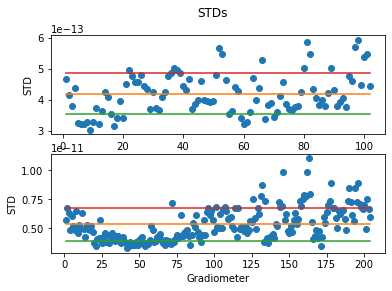

In [5]:
#Try: USING RESAMPLED DATA HERE

m_big_std_with_value, g_big_std_with_value, m_small_std_with_value, g_small_std_with_value, rmse_mags, rmse_grads=RMSE_meg_all(data=filtered_d_resamp, 
    mags=mags, grads=grads, std_lvl=1, plotflag=True, sid='1')

print('Magnetometers with high std:')
m_big_std_with_value

In [6]:
def add_hovering_on_scatter(Plot, Axis, sc_boxes, dots_names):
    
    #Set   generic annotation:
    annot = Axis.annotate("", xy=(0,0), xytext=(5,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    #xytext - how far from the dot the text is, bbox - box with name inside, arrowprops - to draw arrow

    annot.set_visible(False) #hide annotations first

    def update_annot(sc_box, ind):

        pos = sc_box.get_offsets()[ind["ind"][0]]
        annot.xy = pos #resets the xy values from annot above

        #text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
        #                       " ".join([ch_only_name_mag[n] for n in ind["ind"]]))
        #shows both index and name of channel

        text = "{}".format(" ".join([dots_names[n] for n in ind["ind"]]))
        annot.set_text(text) #resets the text from annot above
        

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == Axis:
            for sc_box in sc_boxes: #loop over each separat boxplot with scatter dots in it
                cont, ind = sc_box.contains(event)
                if cont: #if hovering takes place - set annotation to visible
                    update_annot(sc_box, ind)
                    annot.set_visible(True)  
                    Plot.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        Plot.canvas.draw_idle()

    Plot.canvas.mpl_connect("motion_notify_event", hover)

In [7]:
def boxplot_std_hovering(std_data=rmse_mags, tit=None, channel_names=None, sid='1'):

    #Boxplot with hovering annotations: https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-in-matplotlib
        
    from matplotlib import pyplot as plt

    #Boxplot:
    fig, ax = plt.subplots()

    #import seaborn as sns
    #bp=sns.boxplot(data=std_data, orient='h') # DONT USE SEABORN, COS IT DOWSNT WANNA HOVER-ANNOTATE IT, ONLY PYPLOTLIB WORKS FINE

    bp=plt.boxplot(std_data, vert=False)
    sc = plt.scatter(std_data, np.ones(len(std_data)), color=".25") 

    plt.xlabel("Standard deviation")

    #Add hovering:
    ch_name=[m[0] for m in channel_names] #names of channels for annotating the plot
    sc_as_list=[sc]
    add_hovering_on_scatter(fig, ax, sc_as_list, ch_name)

    ax.set_title(tit)

    #Saving interactive figure:
    import pickle
    fig_name='Stds_all_data_'+tit+'.fig.pickle'
    fig_path='../derivatives/sub-'+sid+'/megqc/figures/'+fig_name
    f_handle=open(fig_path, 'wb') # This is for Python 3 - py2 may need `file` instead of `open`, 'wb' means 'write binary' 
    pickle.dump(fig,f_handle) #save
    f_handle.close() #close the binary file
    
    #plt.close('all') #close the figures

    return(fig_path)

In [8]:
%matplotlib qt

tit='Magnetometers'
fig_path_mags=boxplot_std_hovering(std_data=rmse_mags, tit=tit, channel_names=mags, sid='1')

qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


In [9]:
#Reopen saved interactive figure:
import pickle

figx = pickle.load(open(fig_path_mags, 'rb'))
figx.show() # Show the figure, edit it, etc.!

#%matplotlib inline
#DOESNT DO THE HOVERING, HM...

In [10]:
boxplot_std_hovering(std_data=rmse_grads, tit='Gradiometers', channel_names=grads)

'../derivatives/sub-1/megqc/figures/Stds_all_data_Gradiometers.fig.pickle'

In [11]:
#Create a function which will loop over mags or grads (separate epochs) and calculate std (used in RMSE_meg_epoch):
def std_mg(mg_names, df_mg, epoch_numbers):

    import pandas as pd
    
    dict_mg = {}

    for ep in epoch_numbers: #loop over each epoch
        rows_for_ep = [row for row in df_mg.iloc if row.epoch == ep] #take all rows of 1 epoch, all channels.
        #std_epoch = [] #list with stds
        rmse_epoch=[]

        for ch_name in mg_names: #loop over channel names
            data_ch_epoch = [row_mg[ch_name] for row_mg in rows_for_ep] #take the data for 1 epoch for 1 channel
            rmse_ch_ep = RMSE(data_ch_epoch)
            rmse_ch_ep=np.float64(rmse_ch_ep) #convert from ndarray to float
            rmse_epoch.append(rmse_ch_ep)

            #std_ch_ep = np.std(data_ch_epoch) #if want to use std instead
            

        dict_mg[ep] = rmse_epoch

    df_std_mg = pd.DataFrame(dict_mg, index=mg_names)

    return(df_std_mg)

In [12]:
# STD over epochs: use 2 separate data frames for mags and grads in calculations:

def RMSE_meg_epoch(mags=mags, grads=grads, std_lvl=1, n_events=n_events, df_epochs_mags=df_epochs_mags, df_epochs_grads=df_epochs_grads, sid='1'):

#def RMSE_meg_epoch(data=None, std_lvl=1, stim_channel='STI101',  min_duration_event=1.2, epoch_tmin=-0.2, epoch_tmax=1):
    #stim_channel name is users input. but we can also let mne find it itself if 'None' is set? mne seems to have such function.

    # 1) Loop over the epochs of each channel and check for every separate magn and grad and calculate std
    
    eps=list(range(0,n_events)) #list of epoch numbers
   
    mags_names = [mag[0] for mag in mags]
    grads_names = [grad[0] for grad in grads]


    #Apply function from above for mags and grads:
    df_std_mags=std_mg(epoch_numbers=eps, df_mg=df_epochs_mags, mg_names=mags_names)
    df_std_grads=std_mg(epoch_numbers=eps, df_mg=df_epochs_grads, mg_names=grads_names)

    # 2) Check (which epochs for which channel) are over 1STD (or 2, 3, ets STDs) for (this epoch for all channels)

    #Find what is 1 std over all channels per 1 epoch:
    std_std_mags_per_epoch=[]
    std_std_grads_per_epoch=[]
    mean_std_mags_per_epoch=[]
    mean_std_grads_per_epoch=[]

    for ep in eps: #goes over each epoch
        std_std_mags_per_epoch.append(np.std(df_std_mags.iloc[:, ep])) #std of stds of all channels of every single epoch
        std_std_grads_per_epoch.append(np.std(df_std_grads.iloc[:, ep]))

        mean_std_mags_per_epoch.append(np.mean(df_std_mags.iloc[:, ep])) #mean of stds of all channels of every single epoch
        mean_std_grads_per_epoch.append(np.mean(df_std_grads.iloc[:, ep]))


    df_ch_ep_large_std_mags=df_std_mags.copy()
    df_ch_ep_large_std_grads=df_std_grads.copy()

    df_ch_ep_small_std_mags=df_std_mags.copy()
    df_ch_ep_small_std_grads=df_std_grads.copy()

    #Now see which channles in epoch are over 1 std or under -1 std:
    for ep in eps: #goes over each epoch   
        df_ch_ep_large_std_mags.iloc[:,ep] = df_ch_ep_large_std_mags.iloc[:,ep] > mean_std_mags_per_epoch[ep]+std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_large_std_grads.iloc[:,ep] = df_ch_ep_large_std_grads.iloc[:,ep] > mean_std_grads_per_epoch[ep]+std_lvl*std_std_grads_per_epoch[ep] #gradiometers

        df_ch_ep_small_std_mags.iloc[:,ep] = df_ch_ep_small_std_mags.iloc[:,ep] < mean_std_mags_per_epoch[ep]-std_lvl*std_std_mags_per_epoch[ep] #magnetometers
        df_ch_ep_small_std_grads.iloc[:,ep] = df_ch_ep_small_std_grads.iloc[:,ep] < mean_std_grads_per_epoch[ep]-std_lvl*std_std_grads_per_epoch[ep] #gradiometers


    # Create csv files  for the user:

    df_std_mags.to_csv('../derivatives/sub-'+sid+'/megqc/csv files/std_mags_per_epoch.csv')
    
    df_std_grads.to_csv('../derivatives/sub-'+sid+'/megqc/csv files/std_grads_per_epoch.csv')

    df_ch_ep_large_std_mags.to_csv('../derivatives/sub-'+sid+'/megqc/csv files/Large_std_mags_per_epoch.csv')

    df_ch_ep_large_std_grads.to_csv('../derivatives/sub-'+sid+'/megqc/csv files/Large_std_grads_per_epoch.csv')

    df_ch_ep_small_std_mags.to_csv('../derivatives/sub-'+sid+'/megqc/csv files/Small_std_mags_per_epoch.csv')

    df_ch_ep_small_std_grads.to_csv('../derivatives/sub-'+sid+'/megqc/csv files/Small_std_grads_per_epoch.csv')

    return(df_std_mags, df_std_grads)

In [13]:
#try (will output csv files):
# USING NON RESAMPLED DATA

df_std_mags, df_std_grads=RMSE_meg_epoch(mags=mags, grads=grads, std_lvl=1, sid='1') 

In [144]:
def boxplot_std_channel_epoch_hovering_plotly(df_mg, tit, sid):

  #Using plotly!

  import plotly.graph_objects as go

  #transpose the data to plot the boxplots on x axes
  df_mg_transposed = df_mg.T 

  #collect all names of original df into a list to use as tick labels:
  ch_names=list(df_mg_transposed) 

  fig = go.Figure()

  for col in df_mg_transposed:
    fig.add_trace(go.Box(y=df_mg_transposed[col].values, 
      name=df_mg_transposed[col].name, 
      opacity=0.7, 
      boxpoints="all", 
      pointpos=0,
      marker_size=3,
      line_width=1,
      text=df_mg_transposed[col].index))
    fig.update_traces(hovertemplate='Epoch: %{text}'+'<br>STD: %{y: .0f}')
      

  fig.update_layout(
      xaxis = dict(
          tickmode = 'array',
          tickvals = [v for v in range(0, len(ch_names))],
          ticktext = ch_names,
          rangeslider=dict(visible=True)
      ),
      yaxis = dict(
        showexponent = 'all',
        exponentformat = 'e'),
      title={
        'text': "STDs over epochs for "+tit,
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    
  fig.show()

  fig_name='Stds_epochs_per_channel_'+tit+'.html'
  fig_path='../derivatives/sub-'+sid+'/megqc/figures/'+fig_name
  fig.write_html(fig_path)

  return(fig)

  #figure out weird y axis, hovering is too long, simple slider

In [145]:
fig_mags_std_epoch=boxplot_std_channel_epoch_hovering_plotly(df_mg=df_std_mags, tit='Magnetometers', sid='1')

In [15]:
def add_plot_slider(Fig, Axis, ylim_min, ylim_max, x_ax_list):

    from matplotlib.widgets import Slider

    # Choose the Slider color
    slider_color = 'White'
    
    # Set the axis and slider position in the plot
    axis_position = plt.axes([0.2, 0.11, 0.65, 0.03],facecolor = slider_color)
    #slider_position = Slider(axis_position,'Pos', 0.1, 90.0)
    slider_object = Slider(axis_position,label=' ', valmin=-1, valmax=len(x_ax_list)-1)
    
    # update_slider() function to change the graph when the slider is in use
    def update_slider(val):
        pos = slider_object.val
        Axis.axis([pos, pos+15, ylim_min*0.8, ylim_max*1.05]) #0.4e-13, 2.5e-13])
        #arguments: starting position, how many elements on x axis in 1 window, ylimit bottom, ylimit top
        #ylimits are set so that they will be slightly under the minimum of the whole data and over the maxinum.
       
        #arguments: starting position, how many elements on x axis in 1 window, ylimit bottom, ylimit top
        #ylimits are set so that they will be slightly under the minimum of the whole data and over the maxinum.

        Fig.canvas.draw_idle()
    
    # update function called using on_changed() function
    slider_object.on_changed(update_slider)

    return slider_object

In [16]:
def boxplot_std_channel_epoch_hovering(df_mg, tit, sid):

#note: no hovering labels yet - need to do. BUT do we even want such a messy plot? How can we even hover over it?


#This function creates a plot of multiple boxplots: each boxplot is 1 channel. 
#insode of each box: the dots are the stds of epochs for this particular channel. 
#The dots by hoverig over them will show the epoch number.
# data for each epoch and channel is created by RMSE_meg_epoch func and  stored in df_std_mags, df_std_grads 
# and also exported as std_mags_per_epoch.csv and std_grads_per_epoch.csv in derovatives folder

    from matplotlib import pyplot as plt

    #transpose the data to plot the boxplots on x axes
    df_mg_transposed = df_mg.T 

    #exchange the names of columns into numbers for plottings:
    df_mg_transposed_new=df_mg_transposed.copy()
    new_cols=[*range(0, df_mg_transposed.shape[1])]
    df_mg_transposed_new.columns = new_cols

    #collect all names of original df into a list to use as tick labels:
    ch_names=list(df_mg_transposed) 

    #find overall min and max of STDs for this data set to use in slider:
    ylim_min=df_mg_transposed_new.to_numpy().min()
    ylim_max=df_mg_transposed_new.to_numpy().max()


    #plot boxplot and scatter on the loop: one iteration - 1 channel (df column):
    # Setting Plot and Axis variables as subplots()
    # function returns tuple(fig, ax)
    fig, ax = plt.subplots()
    sc_boxes=[] #collect all scatter dots (as plot object, not just values!) in each boxplot here
    for i in range(df_mg_transposed_new.shape[1]):
        bp=plt.boxplot(df_mg_transposed_new.iloc[:,i].values, positions = [i], showfliers=False)

        sc_x=[i]*len(df_mg_transposed_new.iloc[:,i].values)
        sc_y=df_mg_transposed_new.iloc[:,i].values
        sc_box = plt.scatter(sc_x, sc_y, color=".25", s=3) 
        sc_boxes.append(sc_box)
        #sc_x: list of integers, which number is equal to number of data points and value is equal to position on x axis 
        #(example: 200 zeros for first channel, 200 ones for next channel, etc..),
        #sc_y:data values themselves


    #ax.set_xticks(new_cols, labels=ch_names, rotation=90, fontsize=7) #one liner doesnt work in all matplotlib versions it seems
    ax.set_xticks(new_cols)
    ax.set_xticklabels(ch_names, rotation=90, fontsize=7)
    #ax.set_xlim(-0.5, 9.5) #can limit some boxplots here
    ax.set_title('STDs over epochs for '+tit)
    plt.ylabel("Standard deviation")


    #SLIDER: need to return slider object, otherwise it doesnt work.
    slider=add_plot_slider(fig, ax, ylim_min, ylim_max, ch_names)

    #HOVERING:
    #collect epoch numbers here to use as name of dots on scatter
    dots_names=list(str(x) for x in df_std_mags) 
    add_hovering_on_scatter(fig, ax, sc_boxes, dots_names)

    plt.show() 

    ax.set_title(tit)

    #Saving interactive figure:..
    import pickle
    fig_name='Stds_epochs_per_channel_'+tit+'.fig.pickle'
    fig_path='../derivatives/sub-'+sid+'/megqc/figures/'+fig_name
    f_handle=open(fig_path, 'wb') # This is for Python 3 - py2 may need `file` instead of `open`, 'wb' means 'write binary' 
    pickle.dump(fig,f_handle) #save
    f_handle.close() #close the binary file
    
    #plt.close('all') #close the figures

    return(fig_path)

In [17]:
#run interactive plot for magnetometers only:

fig_path_ch_ep=boxplot_std_channel_epoch_hovering(df_mg=df_std_mags, tit='Magnetometers', sid='1')

In [18]:
# Reopen saved interactive figure with pickle: interactive doesnt work any more when reopen!
import pickle
figx = pickle.load(open(fig_path_ch_ep, 'rb'))
figx.show() 

In [19]:
def boxplot_std_channel_epoch_hovering_html(df_mg, tit, sid):

#note: no hovering labels yet - need to do. BUT do we even want such a messy plot? How can we even hover over it?


#This function creates a plot of multiple boxplots: each boxplot is 1 channel. 
#insode of each box: the dots are the stds of epochs for this particular channel. 
#The dots by hoverig over them will show the epoch number.
# data for each epoch and channel is created by RMSE_meg_epoch func and  stored in df_std_mags, df_std_grads 
# and also exported as std_mags_per_epoch.csv and std_grads_per_epoch.csv in derovatives folder

    from matplotlib import pyplot as plt

    #transpose the data to plot the boxplots on x axes
    df_mg_transposed = df_mg.T 

    #exchange the names of columns into numbers for plottings:
    df_mg_transposed_new=df_mg_transposed.copy()
    new_cols=[*range(0, df_mg_transposed.shape[1])]
    df_mg_transposed_new.columns = new_cols

    #collect all names of original df into a list to use as tick labels:
    ch_names=list(df_mg_transposed) 

    #find overall min and max of STDs for this data set to use in slider:
    ylim_min=df_mg_transposed_new.to_numpy().min()
    ylim_max=df_mg_transposed_new.to_numpy().max()


    #plot boxplot and scatter on the loop: one iteration - 1 channel (df column):
    # Setting Plot and Axis variables as subplots()
    # function returns tuple(fig, ax)

    import mpld3 
    dots_names=list(str(x) for x in df_std_mags) 
    labels = dots_names

    fig, ax = plt.subplots()
    #sc_boxes=[] #collect all scatter dots (as plot object, not just values!) in each boxplot here
    for i in range(df_mg_transposed_new.shape[1]):
        bp=plt.boxplot(df_mg_transposed_new.iloc[:,i].values, positions = [i], showfliers=False)

        sc_x=[i]*len(df_mg_transposed_new.iloc[:,i].values)
        sc_y=df_mg_transposed_new.iloc[:,i].values
        sc_box = plt.scatter(sc_x, sc_y, s=2) #, color=".25") 
        tooltip = mpld3.plugins.PointLabelTooltip(sc_box, labels, hoffset=13, voffset=12)
        mpld3.plugins.connect(fig, tooltip)
        #sc_boxes.append(sc_box)
        #sc_x: list of integers, which number is equal to number of data points and value is equal to position on x axis 
        #(example: 200 zeros for first channel, 200 ones for next channel, etc..),
        #sc_y:data values themselves
    
    ind = range(1, len(df_mg)+1)
    ax.set_xticks(ind)
    ax.set_xticklabels(ch_names, rotation=90, fontsize=7)

    #ax.set_xticks(new_cols)
    #ax.set_xticklabels(ch_names, rotation=90, fontsize=7)
    #ax.set_xlim(-0.5, 9.5) #can limit some boxplots here
    ax.set_title('STDs over epochs for '+tit, fontsize = 25)
    plt.ylabel("Standard deviation", fontsize = 18)

    # #SLIDER: need to return slider object, otherwise it doesnt work.
    # slider=add_plot_slider(fig, ax, ylim_min, ylim_max, ch_names)

    # #HOVERING:
    # #collect epoch numbers here to use as name of dots on scatter
    # dots_names=list(str(x) for x in df_std_mags) 
    # add_hovering_on_scatter(fig, ax, sc_boxes, dots_names)

    fig_name='Stds_epochs_per_channel_'+tit+'.html'
    fig_path='../derivatives/sub-'+sid+'/megqc/figures/'+fig_name
    mpld3.save_html(fig, fig_path)


    return(fig_path)

In [20]:
fig_path_html=boxplot_std_channel_epoch_hovering_html(df_mg=df_std_mags, tit='Magnetometers', sid='1')

#THIS WILL CREATE THE FIGURE AND SAVE IN DERIVATIVES/FIGURES AS HTML. JUST OPEN IT THERE

# https://stackoverflow.com/questions/35446525/setting-tick-labels-in-mpld3
# mpld3 does not support ticks! as well as ticks rotation. which we really need, since channel names serve as ticks. :(
# Besides, this package doesnt just export my figures inti html, it needs to write the whole hovering and slider things 
# from the start using their way

In [36]:
df_mg_transposed

,MEG0111,MEG0121,MEG0131,MEG0141,MEG0211,MEG0221,MEG0231,MEG0241,MEG0311,MEG0321,...,MEG2431,MEG2441,MEG2511,MEG2521,MEG2531,MEG2541,MEG2611,MEG2621,MEG2631,MEG2641
0,1.325283e-13,8.536337e-14,7.684146e-14,1.202738e-13,1.067817e-13,8.878270e-14,1.126011e-13,1.500140e-13,1.115910e-13,8.183729e-14,...,1.784601e-13,1.370790e-13,2.083379e-13,1.788291e-13,1.450988e-13,1.520869e-13,1.240793e-13,1.503377e-13,1.389018e-13,1.273587e-13
1,1.163084e-13,9.043086e-14,7.206944e-14,1.165962e-13,9.905670e-14,8.583636e-14,9.422330e-14,9.996268e-14,8.863800e-14,7.651739e-14,...,1.277559e-13,1.052477e-13,1.297498e-13,1.252023e-13,1.476690e-13,1.562558e-13,1.378300e-13,1.362064e-13,1.303850e-13,1.179588e-13
2,1.271144e-13,7.562594e-14,7.998339e-14,1.146335e-13,1.129689e-13,8.980551e-14,1.003671e-13,1.109631e-13,1.141385e-13,8.604699e-14,...,1.551328e-13,1.272688e-13,1.525072e-13,1.344820e-13,1.457132e-13,1.828188e-13,1.149082e-13,1.412861e-13,1.211248e-13,1.099525e-13
3,1.576595e-13,1.451199e-13,9.714823e-14,1.593336e-13,9.712960e-14,7.982587e-14,9.406321e-14,1.225988e-13,1.126485e-13,8.830505e-14,...,1.484085e-13,1.317819e-13,1.410007e-13,1.364850e-13,1.735607e-13,1.880519e-13,1.043045e-13,1.742681e-13,1.575661e-13,1.007685e-13
4,1.646074e-13,8.870210e-14,9.026858e-14,1.255785e-13,1.015332e-13,8.371668e-14,1.060989e-13,1.307062e-13,1.215949e-13,8.095774e-14,...,1.521104e-13,1.299307e-13,1.868027e-13,1.494097e-13,1.592318e-13,1.723779e-13,1.200704e-13,1.685150e-13,1.487058e-13,1.193395e-13
5,1.426171e-13,7.407726e-14,6.608875e-14,1.316862e-13,1.146709e-13,1.036041e-13,1.026894e-13,1.280037e-13,1.255683e-13,1.053932e-13,...,1.620449e-13,1.285686e-13,1.880329e-13,1.773513e-13,1.623847e-13,1.716894e-13,1.062794e-13,1.755381e-13,1.584905e-13,1.093455e-13
6,1.211340e-13,8.786775e-14,9.047839e-14,1.214143e-13,1.087694e-13,8.635031e-14,1.118197e-13,1.339498e-13,9.542093e-14,8.729807e-14,...,1.552456e-13,1.188779e-13,1.648140e-13,1.351194e-13,1.597232e-13,1.757991e-13,1.222510e-13,1.512482e-13,1.395615e-13,1.152248e-13
7,1.480486e-13,1.066715e-13,9.298711e-14,1.417173e-13,1.585455e-13,9.883074e-14,1.330045e-13,2.017956e-13,1.232355e-13,8.595309e-14,...,1.685287e-13,1.575131e-13,2.089485e-13,1.995636e-13,1.965911e-13,1.969232e-13,1.210151e-13,1.670806e-13,1.641380e-13,1.178634e-13
